In [3]:
from utils import resample_brainweb_sim_data
import glob
import matplotlib.pyplot as plt
import numpy as np
#from pytorch.ignite
import h5py
import tqdm
from skimage import transform
import os

In [2]:
data_path_val = "/data/ssahin/kpl_dl_sim/brainweb_3_24/sim_data/"
list_val = glob.glob(data_path_val + '/*.h5')

In [3]:
dict = read_brainweb_sim_data(list_val[6])

print(dict["data"].shape)
print(dict["kPL"].shape)
print(dict["kTRANS"].shape)

(40, 64, 64)
(64, 64)
(64, 64)


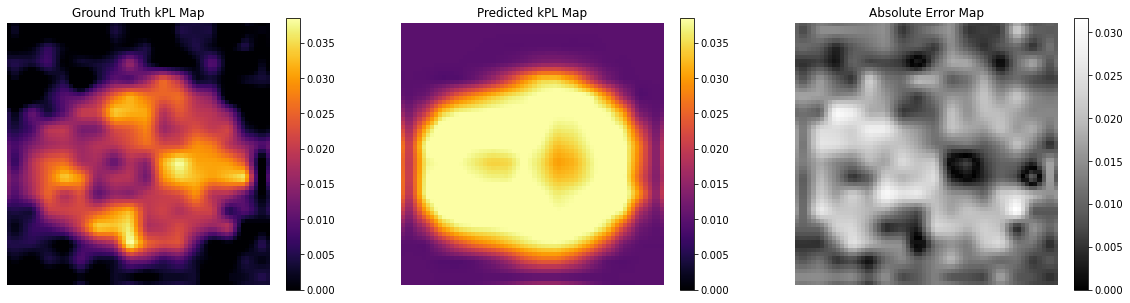

In [14]:
plot_error_map(np.squeeze(dict["data"][25,:,:]), dict["kPL"]+.01)

In [4]:
def plot_error_map(kpl_gt, kpl_pred, **kwargs):

    savepath = kwargs.get('savepath', None)
    clims = kwargs.get('clims', [0, np.max(kpl_gt)])

    error_map = abs(kpl_gt - kpl_pred)

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20,5), ncols=3, nrows=1)  

    img1 = ax1.imshow(kpl_gt, cmap="inferno", vmin=clims[0], vmax=clims[1])
    ax1.set_title('Ground Truth kPL Map')
    fig.colorbar(img1, ax=ax1)
    ax1.axis('off')

    img2 = ax2.imshow(kpl_pred, cmap="inferno", vmin=clims[0], vmax=clims[1])
    ax2.set_title('Predicted kPL Map')
    fig.colorbar(img2, ax=ax2)
    ax2.axis('off')

    img3 = ax3.imshow(error_map, cmap="Greys_r", vmin=0, vmax=np.max(error_map))
    ax3.set_title('Absolute Error Map')
    fig.colorbar(img3, ax=ax3)
    ax3.axis('off')

    plt.show()

    if savepath:
        fig.savefig(savepath)



In [16]:
f = h5py.File("mytestfile.hdf5", "w")


In [17]:
a = np.array([1, 2, 3])
f.create_dataset('dataset_1', data=a)

<HDF5 dataset "dataset_1": shape (3,), type "<i8">

In [25]:
f.close()

In [23]:
f = h5py.File("mytestfile.hdf5", "r")
print(f['dataset_1'][:])

[1 2 3]


In [21]:
f = h5py.File("mytestfile.hdf5", "a")
b = np.array([3, 4, 3])
f.create_dataset('dataset_2', data=b)

<HDF5 dataset "dataset_2": shape (3,), type "<i8">

In [24]:
print(f['dataset_2'][:])

[3 4 3]


## Resize test data

In [25]:
hdf5_dir_test = "/data/ssahin/kpl_dl_sim/brainweb_3_24/sim_data_ood/"
h5files_test = glob.glob(hdf5_dir_test + '/[!v]*.h5')

In [26]:
print(h5files_test)

['/data/ssahin/kpl_dl_sim/brainweb_3_24/sim_data_ood/hi_kPL.h5', '/data/ssahin/kpl_dl_sim/brainweb_3_24/sim_data_ood/low_SNR.h5', '/data/ssahin/kpl_dl_sim/brainweb_3_24/sim_data_ood/hi_SNR.h5', '/data/ssahin/kpl_dl_sim/brainweb_3_24/sim_data_ood/low_kPL.h5']


In [27]:
for file in tqdm.tqdm(h5files_test):
    resample_brainweb_sim_data(file)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 13.09it/s]


In [31]:
filepath = os.path.join(hdf5_dir_test,"vol3_2.h5")

# read in file, initialize arrays
f = h5py.File(filepath, 'r')

data = transform.resize(f["metImages"][:], (64,64,20,3))

f.close()

f = h5py.File(filepath, 'a')

f.create_dataset('metImages_64', data=data)

f.close()

In [15]:
eps= 1e-12

mask = np.array([0, 0, 1, 1, 1, 0, 0])

error_map = abs((gt - y) / gt)*100
error_map2 = (abs(((gt+eps) - (y+eps)) / (gt+eps))*100)
print(error_map)
print(error_map2)

[        nan         inf 33.33333333  0.         80.         50.
         inf]
[0.00000000e+00 1.00000000e+14 3.33333333e+01 0.00000000e+00
 8.00000000e+01 5.00000000e+01 8.00000000e+14]


/home/ssahin/anaconda/envs/reg-36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/ssahin/anaconda/envs/reg-36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [16]:
error_map_masked = error_map2 * mask
print(error_map_masked)

[ 0.          0.         33.33333333  0.         80.          0.
  0.        ]


In [57]:
gt1 = np.array([[0, 4], [5, 0]])
gt2 = np.array([[23, 22], [30, 36]])
gt = np.stack((gt1, gt2))
y1 = np.array([[2, 4], [1, 6]])
y2 = np.array([[23, 28], [32, 31]])
y = np.stack((y1, y2))

m1 = np.array([[0, 1], [1, 1]])
m2 = np.array([[1, 1], [1, 1]])
m = np.stack((m1, m2))
print(gt)
print(gt.shape)
print(y)
print(m)

[[[ 0  4]
  [ 5  0]]

 [[23 22]
  [30 36]]]
(2, 2, 2)
[[[ 2  4]
  [ 1  6]]

 [[23 28]
  [32 31]]]
[[[0 1]
  [1 1]]

 [[1 1]
  [1 1]]]


In [58]:
import torch

y = torch.from_numpy(y)
gt = torch.from_numpy(gt)
m = torch.from_numpy(m)

y_masked = y*m
y_masked = y_masked[y_masked!=0]
gt_masked = gt*m
gt_masked = gt_masked[gt_masked!=0]
#y_masked = y[nz]
#gt_masked = gt[nz]
print(y_masked)
#print(gt_masked)

tensor([ 4,  1,  6, 23, 28, 32, 31])


In [44]:

l1loss = torch.nn.L1Loss(reduction='none')
output = l1loss(torch.from_numpy(y_masked), torch.from_numpy(gt_masked)) / gt_masked
output[output == float('inf')] = 1
print(output)
#loss_l1_batch = torch.sum(output, (1,2))
#print(loss_l1_batch)
loss_l1 = output.sum()
print(loss_l1)

tensor([0.0000, 0.8000, 1.0000, 0.0000, 0.2727, 0.0667, 0.1389],
       dtype=torch.float64)
tensor(2.2783, dtype=torch.float64)


/home/ssahin/anaconda/envs/reg-36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [4]:
x = np.array([1,2,3,4,5,6,7,8])
print(x)
print(x[0:4])
print(x[4:8])

[1 2 3 4 5 6 7 8]
[1 2 3 4]
[5 6 7 8]


In [ ]:
import splitfolders
#splitfolders.ratio("/data/ssahin/kpl_dl_sim", output="/data/ssahin/kpl_dl_sim", seed=1337, ratio=(.8, 0.1,0.1))
splitfolders.ratio("/data/ssahin/kpl_dl_sim/brainweb_3_24", output="/data/ssahin/kpl_dl_sim/brainweb_3_24", seed=888, ratio=(.8, 0.1,0.1))

In [7]:
data_path_test = "/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/"
list_val = glob.glob(data_path_test + '/*.h5')
print(list_val)

['/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/5_4_6.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/10_6_4.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/11_2_4.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/11_3_5.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/5_4_2.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/11_3_1.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/10_6_1.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/5_4_3.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/11_2_1.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/5_4_7.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/10_6_5.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/11_2_5.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/11_3_4.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/5_4_8.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/2_10_4.h5', '/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/2_10_5.h5', '/data/ssahi

In [6]:
import h5py
f = h5py.File(list_val[1], 'r')
print(list(f.keys()))
print("kPL_const" not in f)

f.close()

['data_denoise', 'kPL_PK', 'kPL_const', 'kPL_denoise_PK', 'lac_rsq_PK', 'lac_rsq_denoise_PK', 'mask', 'metImages']
False
